# 本次作业的任务是重现第一节课讲解的模型

## 问题1 CMSA网络的搭建

**你需要搭建一个基于LIF或ELIF神经元，拥有突触动力学的神经网络，通过调节一些参数，可以观察到整个网络中bump-wave模式的转变**

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

torch.set_default_dtype(torch.float16)  # 由于LIF神经元相对比较简单，可以使用float16以节省显存
if torch.cuda.is_available():  # 优先使用gpu进行模拟
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'use device:{device}')
torch.set_grad_enabled(False) # 不使用自动梯度
torch.cuda.empty_cache() # 清空显存
dt = 0.5  # 模拟时间步长 ms
__t__ = 0  # 全局时间变量，用于计算不应期

use device:cuda


### Part1 LIF神经元层的搭建

首先我们定义LIF神经元的动力学：
$$
C\frac{dV}{dt}=-g_L*(V-V_{rest})+I_{input}
$$
其中的input包括外界的输入和突触输入。gL是神经元的漏电导。C是膜电容。

神经元的发放由下式定义：
$$
S=H(V-V_{threshold})*H(t-t_{spike}-\tau)
$$
其中的$\tau$是绝对不应期，发放后和在不应期中的膜电位会保持在V_rest

In [ ]:
class LIFlayer:
    def __init__(self, n:int, threshold=-50.0, reset_value=-70.0, membrane_capacitance=1.0, gL=0.05, refractory_period=5):
        self.shape = (n,n)  # 网络形态
        self.threshold = threshold  # 发放阈值
        self.reset_value = reset_value  # 回复和静息电位，单位mV
        self.membrane_capacitance = membrane_capacitance  # 膜电容，单位nF
        self.gL = gL  # 漏电导，单位μS
        self.refractory = refractory_period  # 不应期，单位ms
        self.potential = torch.ones(self.shape).to(device) * (self.reset_value)  # 膜电位，单位mV
        self.spike = torch.zeros(self.shape).to(device)
        self.spike_time = torch.ones(self.shape).to(device) * (-self.refractory*5)  # 上一次的发放时间

    def update(self, input:torch.Tensor):
        assert input.shape == self.shape
        #Todu 请你完成膜电位、神经元发放和不应期的更新

        return self.potential, self.spike



### Part2 突触层的搭建

AMPA和GABA统一使用指数衰减型突触（ExpSynapse），在这里模拟了突触电流和电导的过程，以及定义了高斯型波包。

$$
I = g*(V-Vrest)
$$
$$
\tau\frac{dg}{dt}=-g+W*S
$$

Pytorch中并没有自带的周期性边界条件。这里自行定义一个处理周期性边界条件的函数。通过scale_up和scale_down两个函数，实现了由I向E网络的缩放，这样可以在一个架构下处理两个不同尺寸的网络。

此外，请你定义连接权重的高斯波包：

$$
W_{ij}=W^{\lambda}e^{-\frac{(x_i-x_j)^2+(y_i-y_j)^2}{\sigma}}
$$

其中$W^{\lambda}$中${\lambda}$代表兴奋性或抑制性的输出，$\sigma$是衰减因子。

In [ ]:

class Synapseslayer:
    def __init__(self, in_neuron:int, out_neuron:int, m_synapses:int, W=0.02, sigma=18, time_constant=3.0, Vrest = 0.0):
        '''m_synapse must be odd. because in the unfold function, if m is even, the index will shift'''
        self.in_neurons = in_neuron
        self.out_neurons = out_neuron
        assert out_neuron/in_neuron % 1 == 0 or in_neuron/out_neuron % 1 == 0  # 确保E_neurons和I_neurons的数量比是整数，以便于后续进行缩放

        self.shape = (out_neuron, out_neuron, m_synapses, m_synapses)
        self.time_constant = time_constant
        self.weight = self.gaussian(m_synapses, W, sigma)
        self.Vrest = Vrest

        self.i =  torch.zeros(self.shape).to(device)  # 突触电流，单位nA
        self.g = torch.zeros(self.shape).to(device)  # 突触电导，单位μS

    def gaussian(self, n, W, sigma):
        #Tosu 请你完成高斯波包函数，返回一个n*n矩阵，其中最大值位于正中间（n为奇数）
         
        return guassian
    
    def update(self, input: torch.Tensor, potential:torch.Tensor):
        assert input.shape == (self.in_neurons, self.in_neurons)

        if self.in_neurons<self.out_neurons:
            input = self.scale_up(input,self.out_neurons//self.in_neurons)
        else:
            input = self.scale_down(input,self.in_neurons//self.out_neurons)
        
        #Todu 请你完成突触电导和电流的更新（提示：使用torch.einsum计算input和weight的逐项乘积，使用repeat将单个神经元的膜电位展开成和突触张量同阶数的张量）
        return self.i
    
    def scale_up(self, input:torch.Tensor, zoom_rate:int):
        a1 = self.shape[3]//2
        a2 = (self.shape[3]-1)//2

        # 以下四个表达式完成了二维矩阵的扩展，以便后面进行平移展开操作
        input = torch.cat((input, input[:,:a1]), dim=1)
        input = torch.cat((input[:,-a1-a2:-a1], input), dim=1)
        input = torch.cat((input, input[:a1,:]), dim=0)
        input = torch.cat((input[-a2-a1:-a1,:], input), dim=0)

        # 平移展开，得到每个突触对应神经元的spike情况
        input = input.unfold(0, self.shape[2], 1).unfold(1, self.shape[3], 1)

        # 将较小的synapselayer的相邻元素重复，得到较大的layer的输入
        input = input.repeat_interleave(zoom_rate,dim=0).repeat_interleave(zoom_rate,dim=1)
        return input
    
    def scale_down(self, input:torch.Tensor, zoom_rate:int): 
        # 和上面的同理
        a1 = self.shape[3]//2
        a2 = (self.shape[3]-1)//2
        input = torch.cat((input, input[:,:a1]), dim=1)
        input = torch.cat((input[:,-a1-a2:-a1], input), dim=1)
        input = torch.cat((input, input[:a1,:]), dim=0)
        input = torch.cat((input[-a2-a1:-a1,:], input), dim=0)

        input = input.unfold(0, self.shape[2], zoom_rate).unfold(1, self.shape[3], zoom_rate)
        return input

### Part3 完成网络构建

将兴奋性神经元层和抑制性神经元层分别组合起来，并完成整个网络的更新

In [ ]:
     
class Network:
    def __init__(self, En, In, rp, We, Wi) -> None:
        self.E_neurons = LIFlayer(n=En,refractory_period=rp)
        self.synapsesEE = Synapseslayer(En,En,101,W=We)
        self.synapsesEI = Synapseslayer(En,In,101,W=We)

        self.I_neurons = LIFlayer(n=In, refractory_period=rp)
        self.synapsesIE = Synapseslayer(In,En,101,Vrest=-80,sigma=400,W=Wi)
        self.synapsesII = Synapseslayer(In,In,101,Vrest=-80,sigma=400,W=Wi)

    def update(self, inputE:torch.Tensor, inputI:torch.Tensor):
        E_potential, E_spike = self.E_neurons.update(inputE+self.synapsesEE.i.sum(dim=(2,3))+self.synapsesIE.i.sum(dim=(2,3)))
        I_potential, I_spike = self.I_neurons.update(inputI+self.synapsesII.i.sum(dim=(2,3))+self.synapsesEI.i.sum(dim=(2,3)))
        self.synapsesEE.update(E_spike, E_potential)
        self.synapsesEI.update(E_spike, I_potential)
        self.synapsesIE.update(I_spike, E_potential)
        self.synapsesII.update(I_spike, I_potential)

        return E_potential,E_spike

### Part4运行模拟

模拟的更新方式已在上文定义。在模拟时，可以首先进行一段有输入的过程，然后撤去输入，观察网络的自发动力学。

最后输出模拟结束后的图像。最终结果需要看到bump, wave和critical state三种模式。

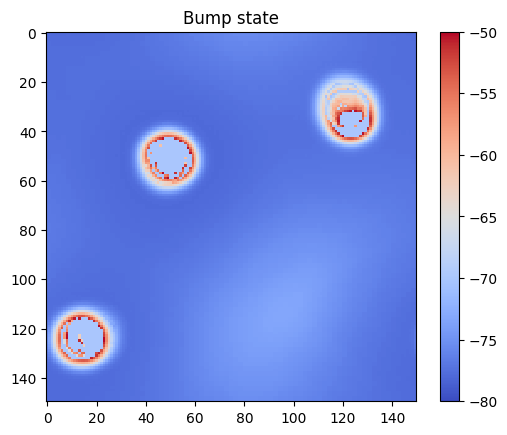
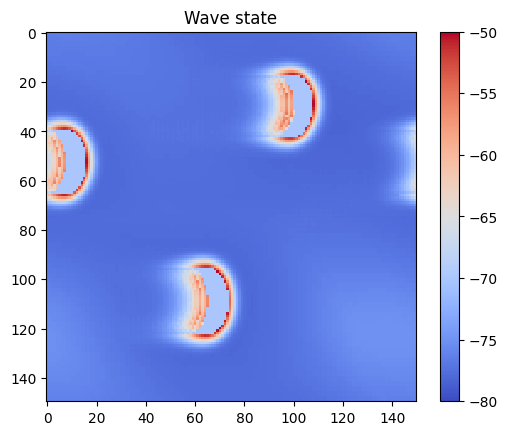
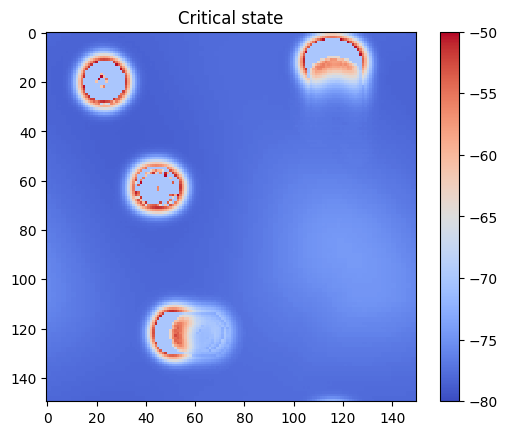

In [ ]:
En =  # 兴奋性神经元网格边长数
In =  # 抑制性神经元网格边长数，En与In之比需要为整数
runtime1 = 30  # 有外界输入的时间
runtime = 200  # 自发动力学的时间
rp =   # 不应期时间
We =   # 兴奋性连接权重
Wi =   # 抑制性连接权重
net = Network(En,In,rp=rp,We=We,Wi=Wi)
voltage_list = []

for i in range(int(runtime1/dt)):
    __t__+=dt
    E_potential, E_spike= net.update(torch.rand((En,En)).to(device)*5, torch.rand((In,In)).to(device)*5)  # 平均外界输入电流2.5nA
    voltage_list.append(E_potential.clone().cpu())

for i in range(int(runtime/dt)):
    __t__+=dt
    E_potential, E_spike= net.update(torch.rand((En,En)).to(device)*0, torch.rand((In,In)).to(device)*0)
    voltage_list.append(E_potential.clone().cpu())


plt.imshow(E_potential.cpu(), cmap='coolwarm')
plt.title(f'We={We}, Wi={Wi}, rp={rp}ms')
plt.colorbar()
plt.show()

# 可以保存数据，使用Watch_Pattern.py观看动画
V = np.array([v.numpy() for v in voltage_list])
np.save(f'We={We}, Wi={Wi}, rp={rp}ms',V)

## 问题2 相变过程的探究

在本问题中，需要调整一个参数，模拟出整个相变过程，并通过定义一个序参量绘制相变曲线。序参量可以选择陈国璋老师课上讲过的方式，也可以自行定义。

### Part1 序参量的定义

序参量（Order Parameter）是物理里用于衡量相变系统有序程度的量。一般来说，序参量的变化是由对称性破缺引起的（定义来自Wikipedia）。

在这里，我们可以定义的常见序参量就是Pattern方向的一致性$\Phi$

$$
\Phi=\frac{\left\lvert \sum {\overrightarrow{v_i} }\right\rvert}{\sum {\overrightarrow{\left\lvert  v_i \right\rvert} }}
$$

下面请你完成$\Phi$的定义，并计算示例文件的$\Phi$，并结合不同斑图的状态解释这个序参量的物理含义的解释

In [ ]:
def calcu_center(image)->list:
    #image是包含多个斑图的二维数组
    #Todu 计算一个Pattern的中心位置，返回包含所有中心位置的列表。

    return

def calcu_Phi(data:torch.Tensor, center_list):
    #data的0维是时间，1和2维是image
    velocity_list=[]
    last_center_list = []
    for i in range():        
        for center in center_list:
            for laster_center in last_center_list:
                #Todu 计算速度
                pass

        last_center_list = center_list

    #Todu 计算Phi 
    Phi = 
    return Phi

data = np.load("Bump_example.npy")
print(calcu_Phi(data))
data = np.load("Wave_example.npy")
print(calcu_Phi(data))
data = np.load("Critical_example.npy")
print(calcu_Phi(data))

### Part2 绘制序参量-外部条件的变化曲线

可以选取一个全局参数作为自变量（例如We/Wi、不应期时间等等），自行选择自变量范围和步长，绘制相变曲线，并对你的结果结合课上所学理论给出解释。

也鼓励大家尝试定义其他类型的序参量并进行测试。

### Part3附加题 临界态对注意力模式的影响

在不同状态下给定一个输入图案，探究Pattern聚焦到图案这一过程的特点。从而解释为什么说大脑应该处于临界态。

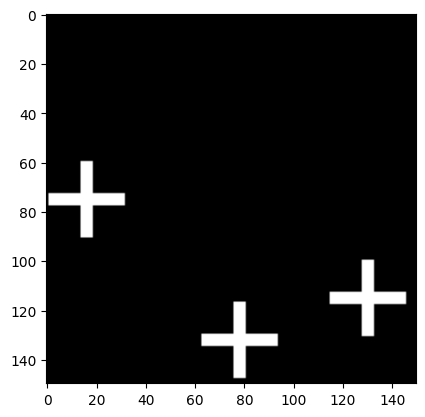

In [ ]:
image = np.load('image_cross.npy')
plt.imshow(image,cmap='gray')
plt.show()

#Todu 将image作为输入

## 问题3 更加复杂模型下的动力学性质

**本问题是一个开放性问题，不要求在本次完成。希望学有余力的同学提前思考一下，可以作为最后一次大作业的Discussion**

要求：围绕大脑中的临界态和相变现象研究一个课题，以下给出几个方向可供参考

1.多层动力学网络：考虑多个上述网络的耦合

2.考虑不同种类的抑制性神经元：抑制性神经元（又称中间神经元，interneuron），常见的有PV、SsT、VIP等，可以考虑引入这些神经元观察其对网络动力学特性的影响

3.大脑中其他类型的临界态探究

4.考虑一些学习过程（如LTP等），观察对临界态状态的影响